In [1]:
#Imports
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import hvplot.pandas
import numpy as np
import pypfopt
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt import plotting
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
import seaborn as sns
import scipy.optimize as sco

# Portfolio Optimizer
### Enter US stocks as ticker only. ASX stock enter .AX after ticker e.g.(BHP.AX)
### Enter the corrosponding Index as the LAST ticker e.g(NDX)

In [2]:
# META
# AAPL
# MSFT
# GOOG
# AMZN
# NDX

#US Stocks enter ticker only. ASX stocks enter ticker + .AX e.g.(BHP.AX) SET INDEX AS LAST TICKER

tickers = []  # Initialize an empty list to store tickers

while True:
    ticker = input("Enter a ticker (or 'done' to finish): ")
    if ticker.lower() == 'done':
        break  # Exit the loop if the user enters 'done'
    tickers.append(ticker)

print("List of tickers:", tickers)

Enter a ticker (or 'done' to finish):  META
Enter a ticker (or 'done' to finish):  AAPL
Enter a ticker (or 'done' to finish):  MSFT
Enter a ticker (or 'done' to finish):  GOOG
Enter a ticker (or 'done' to finish):  AMZN
Enter a ticker (or 'done' to finish):  NDX
Enter a ticker (or 'done' to finish):  done


List of tickers: ['META', 'AAPL', 'MSFT', 'GOOG', 'AMZN', 'NDX']


In [3]:
# Calculate the start and end dates for the past 10 years
end_date = datetime.today().date()
start_date = end_date - timedelta(days=10*365)  # 10 years * 365 days

# Fetch historical price data
stock_data = yf.download(tickers, start=start_date, end=end_date)

#Drop Nulls. Remove high, low, open data. 
print(stock_data.isnull().sum())
stock_data = stock_data.drop(columns=['Open', 'Volume', 'Close', 'High', 'Low'])

# Print the retrieved data
stock_data

[*********************100%%**********************]  6 of 6 completed
Adj Close  AAPL    0
           AMZN    0
           GOOG    0
           META    0
           MSFT    0
           NDX     0
Close      AAPL    0
           AMZN    0
           GOOG    0
           META    0
           MSFT    0
           NDX     0
High       AAPL    0
           AMZN    0
           GOOG    0
           META    0
           MSFT    0
           NDX     0
Low        AAPL    0
           AMZN    0
           GOOG    0
           META    0
           MSFT    0
           NDX     0
Open       AAPL    0
           AMZN    0
           GOOG    0
           META    0
           MSFT    0
           NDX     0
Volume     AAPL    0
           AMZN    0
           GOOG    0
           META    0
           MSFT    0
           NDX     0
dtype: int64


Adj Close                                                  \
                  AAPL        AMZN        GOOG        META        MSFT   
Date                                                                     
2013-08-23   15.616632   14.500500   21.674009   40.549999   29.100157   
2013-08-26   15.677415   14.310500   21.578867   41.340000   28.597713   
2013-08-27   15.229195   14.046500   21.174383   39.639999   27.852409   
2013-08-28   15.301198   14.079000   21.134533   40.549999   27.651430   
2013-08-29   15.326136   14.199000   21.305889   41.279999   28.095274   
...                ...         ...         ...         ...         ...   
2023-08-14  179.460007  140.570007  131.830002  306.190002  323.355408   
2023-08-15  177.449997  137.669998  130.270004  301.950012  321.179962   
2023-08-16  176.570007  135.070007  129.110001  294.290009  320.399994   
2023-08-17  174.000000  133.979996  130.460007  285.089996  316.880005   
2023-08-18  174.490005  133.220001  128.110001  283.250000  316.480011   

                          
                     NDX  
Date                      
2013-08-23   3124.270020  
2013-08-26   3122.669922  
2013-08-27   3059.580078  
2013-08-28   3072.169922  
2013-08-29   3093.360107  
...                  ...  
2023-08-14  15205.589844  
2023-08-15  15037.650391  
2023-08-16  14876.469727  
2023-08-17  14715.809570  
2023-08-18  14694.839844  

[2514 rows x 6 columns]

In [4]:
# Fetch Risk Free rate using US10 Treasury Bond

# Calculate the start and end dates for the past 10 years
end_date = datetime.today().date()
start_date = end_date - timedelta(days=10*365)  # 10 years * 365 days

# Fetch historical price data
us10_data = yf.download("^TNX", start=start_date, end=end_date)

#Drop Nulls. Remove high, low, open data. 
us10_data = us10_data.drop(columns=['Open', 'Volume', 'Close', 'High', 'Low'])
us10_data

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2013-08-23,2.818
2013-08-26,2.805
2013-08-27,2.721
2013-08-28,2.782
2013-08-29,2.751
...,...
2023-08-14,4.184
2023-08-15,4.221
2023-08-16,4.258


In [5]:
#Calculate daily change stocks
combined_returns = stock_data.pct_change()
combined_returns = combined_returns.dropna()
combined_returns

Adj Close                                                  
                AAPL      AMZN      GOOG      META      MSFT       NDX
Date                                                                  
2013-08-26  0.003892 -0.013103 -0.004390  0.019482 -0.017266 -0.000512
2013-08-27 -0.028590 -0.018448 -0.018744 -0.041122 -0.026062 -0.020204
2013-08-28  0.004728  0.002314 -0.001882  0.022957 -0.007216  0.004115
2013-08-29  0.001630  0.008523  0.008108  0.018002  0.016051  0.006897
2013-08-30 -0.009112 -0.010564 -0.009972  0.000242 -0.004471 -0.006320
...              ...       ...       ...       ...       ...       ...
2023-08-14  0.009393  0.015606  0.012753  0.015084  0.009439  0.011813
2023-08-15 -0.011200 -0.020630 -0.011833 -0.013848 -0.006728 -0.011045
2023-08-16 -0.004959 -0.018886 -0.008905 -0.025368 -0.002428 -0.010718
2023-08-17 -0.014555 -0.008070  0.010456 -0.031262 -0.010986 -0.010800
2023-08-18  0.002816 -0.005672 -0.018013 -0.006454 -0.001262 -0.001425

[2513 rows x 6 columns]

In [6]:
#Drop level with Adj Close
combined_returns.columns = combined_returns.columns.droplevel(0)

In [7]:
combined_returns

,AAPL,AMZN,GOOG,META,MSFT,NDX
Date,,,,,,
2013-08-26,0.003892,-0.013103,-0.004390,0.019482,-0.017266,-0.000512
2013-08-27,-0.028590,-0.018448,-0.018744,-0.041122,-0.026062,-0.020204
2013-08-28,0.004728,0.002314,-0.001882,0.022957,-0.007216,0.004115
2013-08-29,0.001630,0.008523,0.008108,0.018002,0.016051,0.006897
2013-08-30,-0.009112,-0.010564,-0.009972,0.000242,-0.004471,-0.006320
...,...,...,...,...,...,...
2023-08-14,0.009393,0.015606,0.012753,0.015084,0.009439,0.011813
2023-08-15,-0.011200,-0.020630,-0.011833,-0.013848,-0.006728,-0.011045
2023-08-16,-0.004959,-0.018886,-0.008905,-0.025368,-0.002428,-0.010718


In [8]:
#Calculate daily change 10yr treasury
us10_daily_change = us10_data.pct_change()
us10_daily_change = us10_daily_change.dropna()
us10_daily_change

,Adj Close
Date,
2013-08-26,-0.004613
2013-08-27,-0.029947
2013-08-28,0.022418
2013-08-29,-0.011143
2013-08-30,-0.000727
...,...
2023-08-14,0.003839
2023-08-15,0.008843
2023-08-16,0.008766


In [9]:
# Plot Daily returns on hvplot.line
combined_returns.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [10]:
# Calculate cumulative returns of all portfolios
cum_returns = (1 + combined_returns).cumprod(axis=0)
cum_returns

# Plot cumulative returns
cum_returns.hvplot(
    width=1000,
    height=500
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [32]:
#Calcuate rolling 180 day mean of cumulative stock price returns
cum_returns.rolling(window=180).mean().hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [35]:
#Calculate rolling 180 standard deviation of cumulative stock prices
cum_returns.rolling(window=180).std().hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [29]:
#Calculate varience
portfolio_variance = combined_returns.var()
portfolio_variance
portfolio_variance.hvplot.bar( title="Variance")

:Bars   [index]   (0)

In [30]:
# Calculate the annualized `std`
portfolio_std = combined_returns.std() * np.sqrt(252)
#portfolio_std.plot(kind="bar", title="Sharpe Ratios")
portfolio_std.hvplot.bar( title="annualised standard deviation")

:Bars   [index]   (0)

In [14]:
#Find covariance of stocks with Index
cov_matrix = combined_returns.cov()
cov_matrix

,AAPL,AMZN,GOOG,META,MSFT,NDX
AAPL,0.000323,0.000200,0.000187,0.000222,0.000202,0.000198
AMZN,0.000200,0.000436,0.000235,0.000285,0.000221,0.000210
GOOG,0.000187,0.000235,0.000310,0.000265,0.000211,0.000192
META,0.000222,0.000285,0.000265,0.000567,0.000224,0.000227
MSFT,0.000202,0.000221,0.000211,0.000224,0.000292,0.000199
NDX,0.000198,0.000210,0.000192,0.000227,0.000199,0.000186


In [15]:
#Find variance of the Index ticker
variance_index = combined_returns.iloc[:,-1].var()
variance_index

0.00018573688108043616

In [16]:
#Obtain the beta of each stock

# Create an empty DataFrame to store beta values
beta_df = pd.DataFrame(columns=['Ticker', 'Beta'])

# Iterate through the index tickers and corresponding matrix rows
for i, ticker in enumerate(tickers):
    ticker_cov_with_index = cov_matrix.iloc[i, -1]  # Get the value from the last column of the corresponding row
    # print(f"{ticker}: {ticker_cov_with_index}")
    
    beta = ticker_cov_with_index / variance_index
    print(f'{ticker} Beta: {beta}')
    beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
    
beta_df.set_index('Ticker').sort_values(by='Beta')


META Beta: 1.0671651222460088
AAPL Beta: 1.128074162455756
MSFT Beta: 1.0339193713929706
GOOG Beta: 1.2220823171206674
AMZN Beta: 1.0700057828175178
NDX Beta: 1.0000000000000004


/var/folders/ht/y_wwy_fj1lb6tq55gtx7nmc00000gn/T/ipykernel_23588/2518297373.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
/var/folders/ht/y_wwy_fj1lb6tq55gtx7nmc00000gn/T/ipykernel_23588/2518297373.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
/var/folders/ht/y_wwy_fj1lb6tq55gtx7nmc00000gn/T/ipykernel_23588/2518297373.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
/var/folders/ht/y_wwy_fj1lb6tq55gtx7nmc00000gn/T/ipykernel_23588/2518297373.py:13: FutureWarning: The frame.appe

,Beta
Ticker,
NDX,1.000000
MSFT,1.033919
META,1.067165
AMZN,1.070006
AAPL,1.128074
GOOG,1.222082


In [17]:
#Calculate Sharpe ratios
us10_mean = pd.DataFrame(us10_daily_change.mean())
us10_mean = us10_mean.iloc[0,0]
print(us10_mean)

sharpe_ratios = ((combined_returns.mean()- us10_mean) * 252) / (combined_returns.std() * np.sqrt(252))
sharpe_ratios


0.0006451654389859537


AAPL    0.421575
AMZN    0.345904
GOOG    0.194951
META    0.277180
MSFT    0.418613
NDX     0.074882
dtype: float64

In [31]:
#Plot Sharpe ratios 
sharpe_ratios.hvplot.bar(title="Sharpe Ratios")

:Bars   [index]   (0)

# Efficent Fronter

In [19]:
#Drop Index from stock_data
stock_data_minus_index = stock_data.iloc[:,:-1]
stock_data_minus_index

Adj Close                                                
                  AAPL        AMZN        GOOG        META        MSFT
Date                                                                  
2013-08-23   15.616632   14.500500   21.674009   40.549999   29.100157
2013-08-26   15.677415   14.310500   21.578867   41.340000   28.597713
2013-08-27   15.229195   14.046500   21.174383   39.639999   27.852409
2013-08-28   15.301198   14.079000   21.134533   40.549999   27.651430
2013-08-29   15.326136   14.199000   21.305889   41.279999   28.095274
...                ...         ...         ...         ...         ...
2023-08-14  179.460007  140.570007  131.830002  306.190002  323.355408
2023-08-15  177.449997  137.669998  130.270004  301.950012  321.179962
2023-08-16  176.570007  135.070007  129.110001  294.290009  320.399994
2023-08-17  174.000000  133.979996  130.460007  285.089996  316.880005
2023-08-18  174.490005  133.220001  128.110001  283.250000  316.480011

[2514 rows x 5 columns]

In [20]:
#Calculate Expected returns for efficient frontier model using historical returns
mu = mean_historical_return(stock_data_minus_index)
mu

Adj Close  AAPL    0.273827
           AMZN    0.249070
           GOOG    0.195031
           META    0.215215
           MSFT    0.270380
dtype: float64

<Axes: >

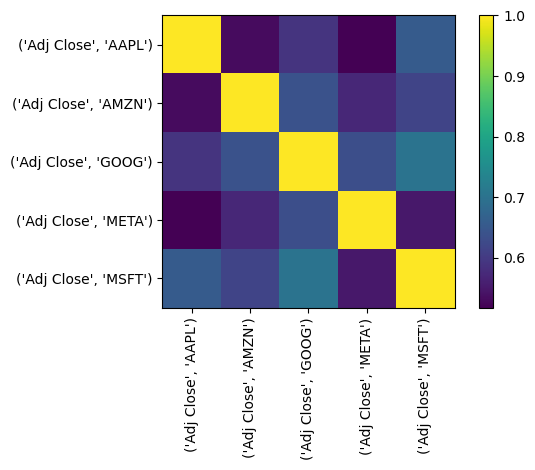

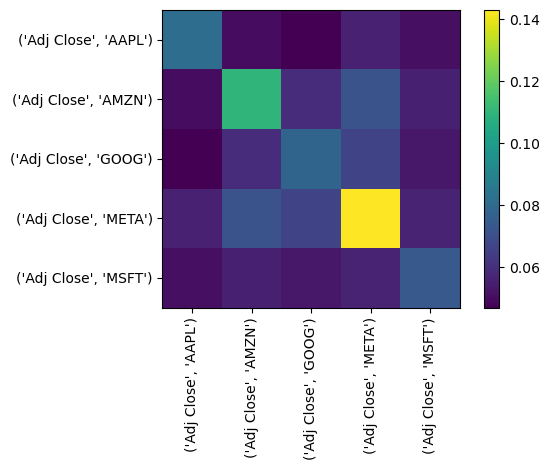

In [21]:
#Calculate Risk for efficient frontier model using annualised sample covariance. 
s = risk_matrix(stock_data_minus_index, method='sample_cov')

#Plot correlation
plotting.plot_covariance(s,show_tickers=True,plot_correlation=True)

#Plot covariance
plotting.plot_covariance(s,show_tickers=True,plot_correlation=False)

In [22]:
#annualised Risk Free Rate
annual_risk_free_rate = pd.DataFrame(us10_data.mean())
annual_risk_free_rate = float(annual_risk_free_rate.iloc[0,0]) / 100
print(round(annual_risk_free_rate,2))

0.02


Expected annual return: 24.7%
Annual volatility: 24.3%
Sharpe Ratio: 0.92


<Axes: xlabel='Weight'>

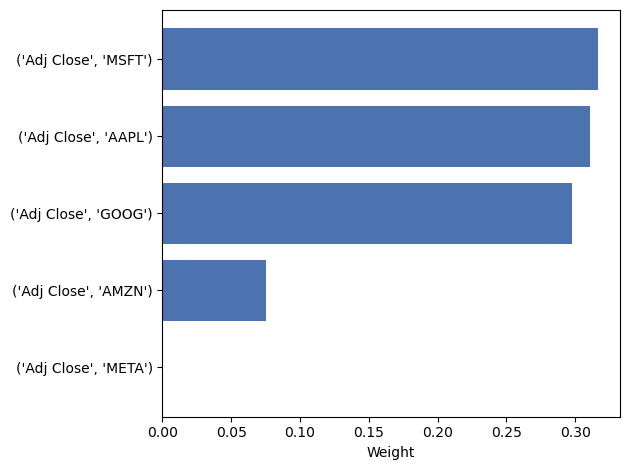

In [23]:
ef = EfficientFrontier(mu, s)
weights = ef.min_volatility()
ef.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free_rate)
plotting.plot_weights(weights)


Expected annual return: 27.0%
Annual volatility: 25.0%
Sharpe Ratio: 0.99


<Axes: xlabel='Weight'>

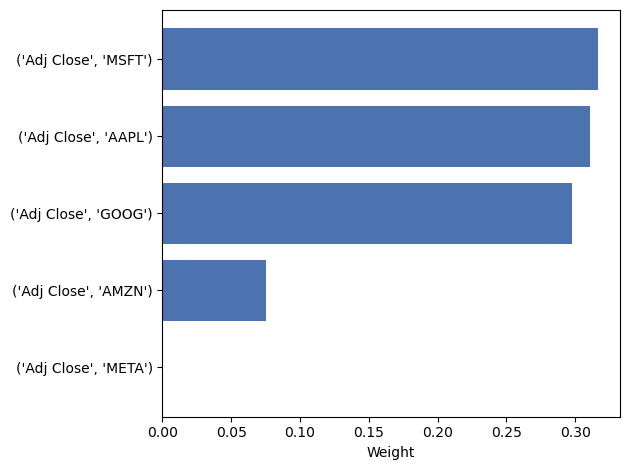

In [24]:
ef = EfficientFrontier(mu, s)
ef.max_sharpe(risk_free_rate=annual_risk_free_rate)
ef.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free_rate)
plotting.plot_weights(weights)

Expected annual return: 26.4%
Annual volatility: 24.8%
Sharpe Ratio: 0.97


/Users/matthewtsiglopoulos/anaconda3/envs/dev/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


<Axes: xlabel='Weight'>

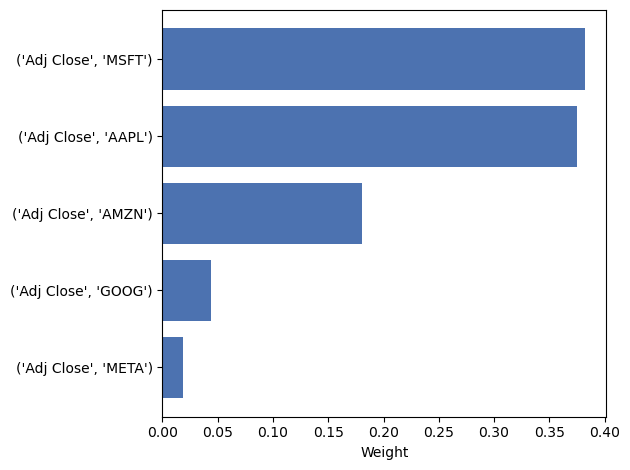

In [25]:
ef = EfficientFrontier(mu, s)
ef.add_objective(objective_functions.L2_reg, gamma=0.05)
weights = ef.max_sharpe(risk_free_rate=annual_risk_free_rate)
ef.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free_rate)
plotting.plot_weights(weights)

# Efficient Frontier Option 2

In [26]:
ticker_count_minus_1 = int(len(tickers)-1)
ticker_count_minus_1

5

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.28
Annualised Volatility: 0.25


           Adj Close                         
                AAPL   AMZN  GOOG META   MSFT
allocation      43.1  13.93  0.18  2.4  40.38
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.26
Annualised Volatility: 0.24


           Adj Close                          
                AAPL  AMZN   GOOG  META   MSFT
allocation     31.38  8.41  28.03  0.35  31.83


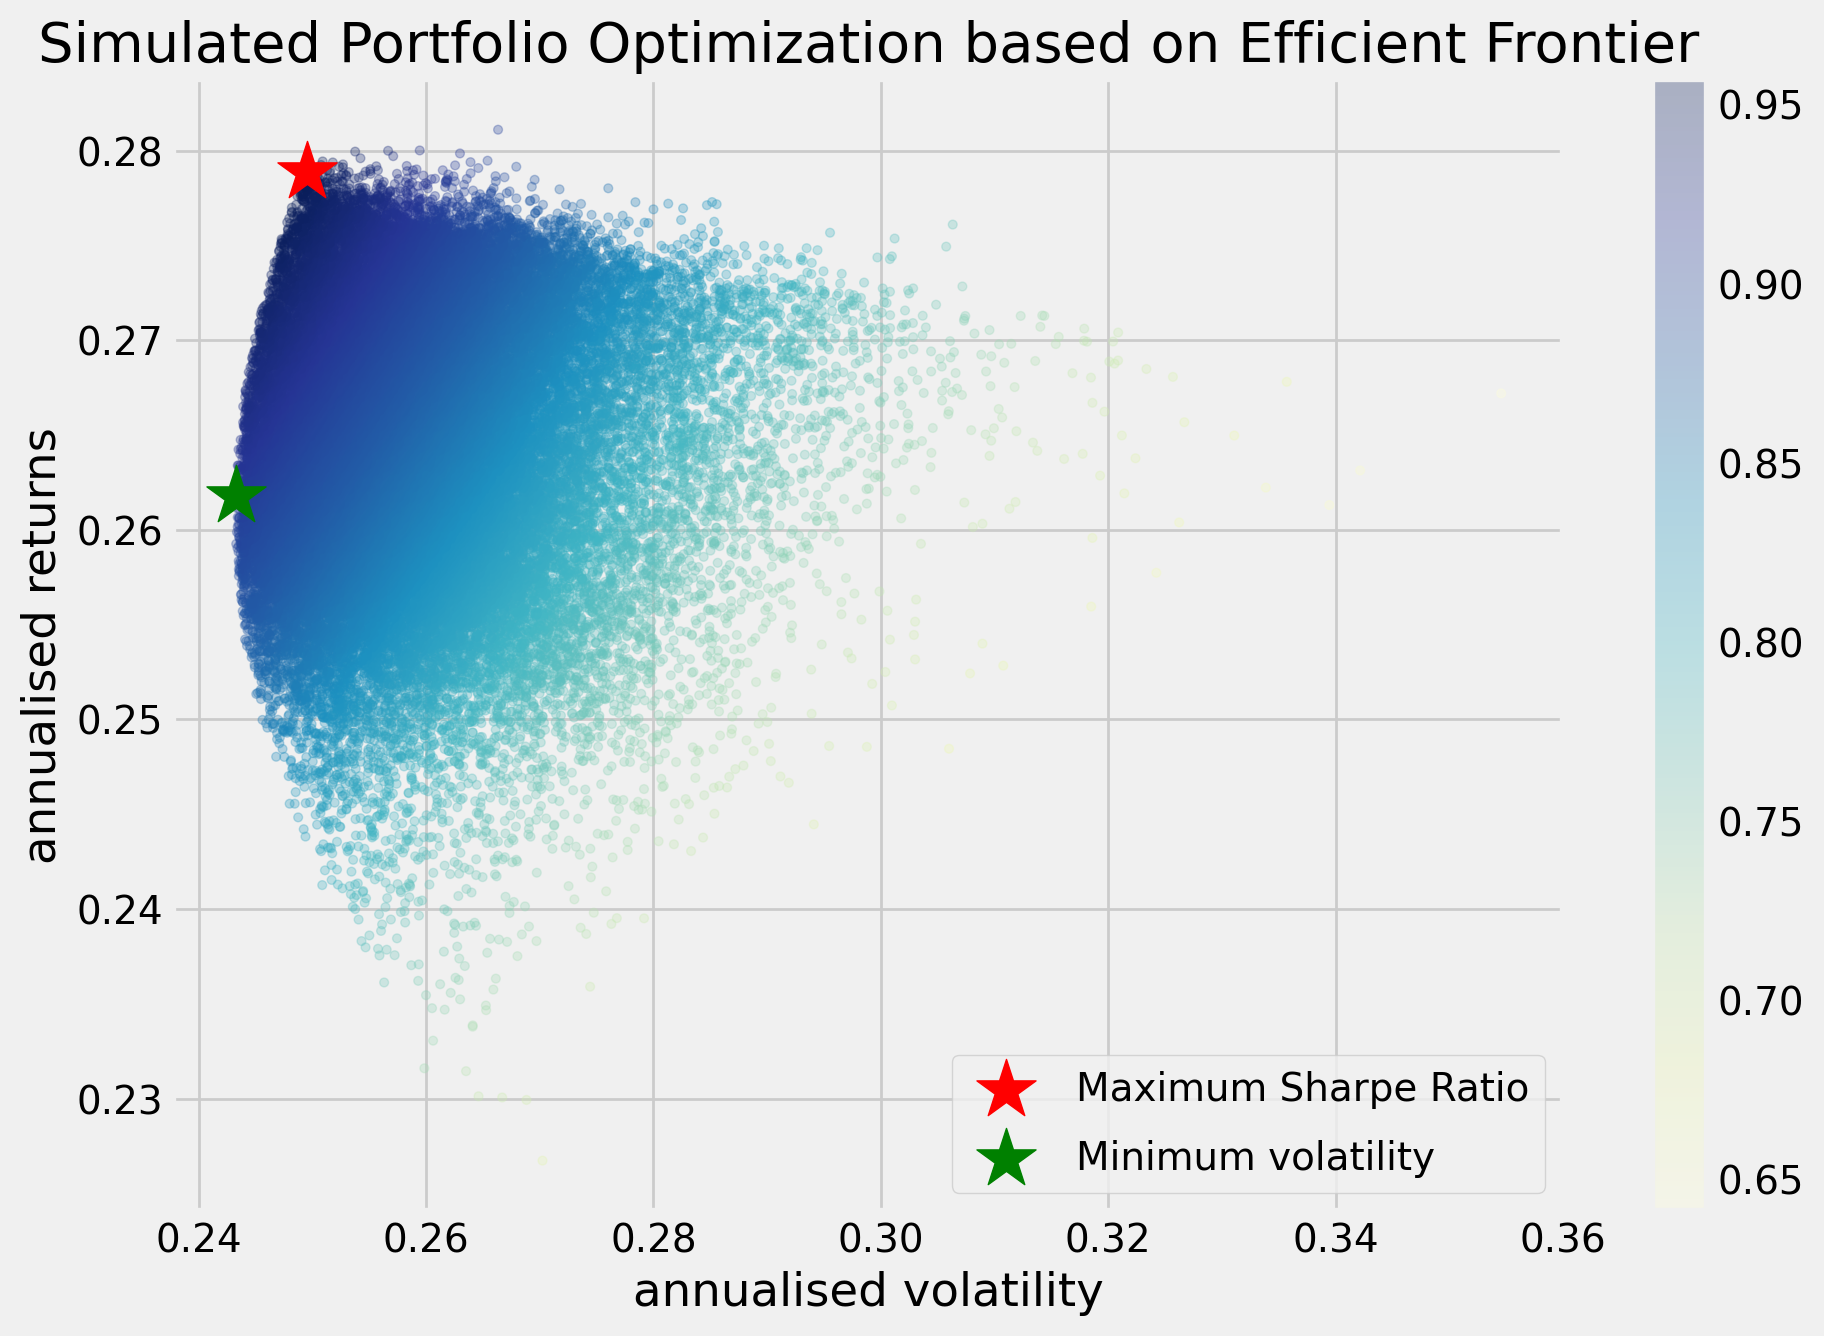

In [27]:
#New efficient frontier - Option 2 Using 25000 random portfolios and finding the max sharpe and min volatility allocations-----------------------------------------------------------------------------
# Reference https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f



plt.style.use('fivethirtyeight')
np.random.seed(777)

#configure jupyter notebook to display Matplotlib in high-resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((ticker_count_minus_1,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(ticker_count_minus_1)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

#inputs for the varibles above
returns = stock_data_minus_index.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.04

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=stock_data_minus_index.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=stock_data_minus_index.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r', s=500, label='Maximum Sharpe Ratio')
    plt.scatter(sdp_min,rp_min,marker='*', color='g', s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    
#To display the frontier and data:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)